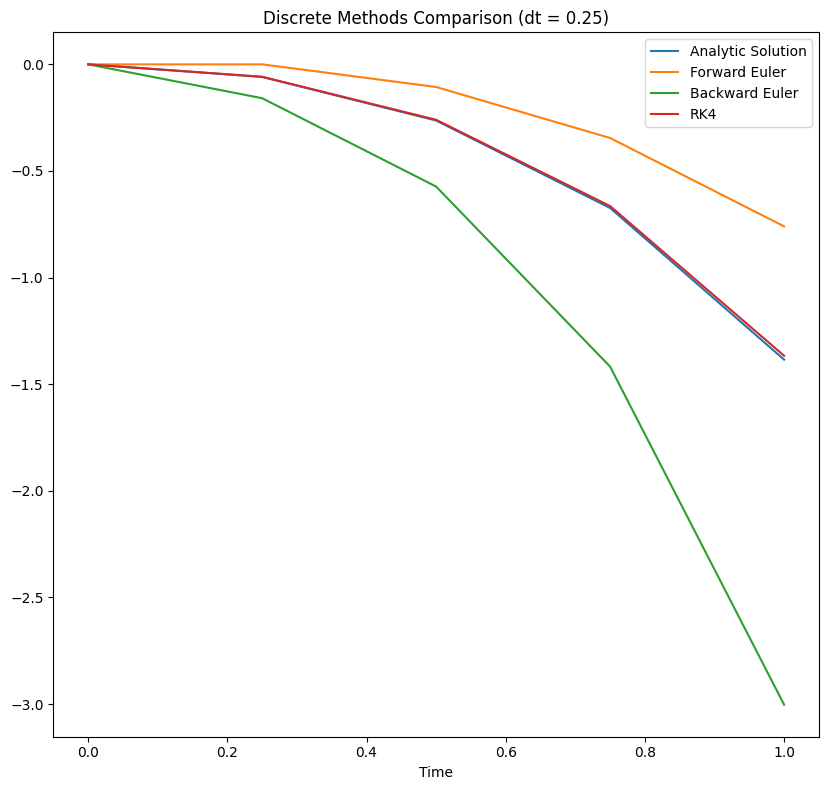

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
import math

def pendulum_dynamics(x):
    """
    Pendulum dynamics: d²θ/dt² = -(g/l) * sin(θ)
    State vector x = [θ, dθ/dt]
    """
    l = 1.0
    g = 9.81
    
    theta = x[0]
    theta_dot = x[1]
    
    theta_ddot = -(g/l) * np.sin(theta)
    
    return np.array([theta_dot, theta_ddot])

def polynomial_func(x: np.ndarray) -> np.ndarray:
    a = 4.62
    b = -4.68
    c = -5.74
    d = -7.85
    x = x.reshape((2,))
    A = np.array([[0, 1], [-c/a, -b/a]])
    B = np.array([0, d/a])
    x_d = A @ x + B
    return x_d.reshape((1,2))

def exact_discrete_solution(x0, Tf, h):
    a = 4.62
    b = -4.68
    c = -5.74
    d = -7.85
    A = np.array([[0, 1], [-c/a, -b/a]])
    B = np.array([0, d/a])
    Ah = expm(A * h)
    Bh = np.zeros((2,)).astype(np.float64)
    for i in range(20):
        Bh_i = ((Ah ** (i-1) * h**i) / math.factorial(i)) @ B
        print(Bh_i)
        Bh += Bh_i
    Bh = Bh.reshape((2,))
    
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0

    for k in range(len(t) - 1):
        x_hist[:, k + 1] = Ah @ x_hist[:, k] + Bh

    return x_hist, t

def forward_euler(fun, x0, Tf, h):
    """
    Explicit Euler integration method
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0
    
    for k in range(len(t) - 1):
        x_hist[:, k + 1] = x_hist[:, k] + h * fun(x_hist[:, k])
    
    return x_hist, t

def backward_euler(fun, x0, Tf, h, tol=1e-8, max_iter=100):
    """
    Implicit Euler integration method using fixed-point iteration
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0
    
    for k in range(len(t) - 1):
        x_hist[:, k + 1] = x_hist[:, k]  # Initial guess
        
        for i in range(max_iter):
            x_next = x_hist[:, k] + h * fun(x_hist[:, k + 1])
            error = np.linalg.norm(x_next - x_hist[:, k + 1])
            x_hist[:, k + 1] = x_next
            
            if error < tol:
                break
    
    return x_hist, t

def runge_kutta4(fun, x0, Tf, h):
    """
    4th order Runge-Kutta integration method
    """
    t = np.arange(0, Tf + h, h)
    x_hist = np.zeros((len(x0), len(t)))
    x_hist[:, 0] = x0
    
    for k in range(len(t) - 1):
        k1 = fun(x_hist[:, k])
        k2 = fun(x_hist[:, k] + 0.5 * h * k1)
        k3 = fun(x_hist[:, k] + 0.5 * h * k2)
        k4 = fun(x_hist[:, k] + h * k3)
        
        x_hist[:, k + 1] = x_hist[:, k] + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    
    return x_hist, t

# Test all integrators
x0 = np.array([0.0, 0.0])  # Initial state: [angle, angular_velocity]
Tf = 1.0
h = 0.25

# Analytic solution
c1 = -0.978994
c2 = -0.406023
lambda_1 = -0.717827
lambda_2 = 1.73081
x0_ = 7.95/5.74
t = np.arange(0, Tf + h, h)
x = c1 * np.exp(lambda_1 * t) + c2 * np.exp(lambda_2 * t) + x0_

# Exact discrete solution
# x_exact, t_exact = exact_discrete_solution(x0, Tf, h)

# Forward Euler
x_fe, t_fe = forward_euler(polynomial_func, x0, Tf, h)

# Backward Euler  
x_be, t_be = backward_euler(polynomial_func, x0, Tf, h)

# Runge-Kutta 4
x_rk4, t_rk4 = runge_kutta4(polynomial_func, x0, Tf, h)

# Plot results
plt.figure(figsize=(24, 8))

# Plot analytic solution
plt.subplot(1, 3, 1)
plt.plot(t, x, label='Analytic Solution')
plt.plot(t_fe, x_fe[0, :], label='Forward Euler')
plt.plot(t_be, x_be[0, :], label='Backward Euler')
plt.plot(t_rk4, x_rk4[0, :], label='RK4')
plt.xlabel('Time')
plt.title('Discrete Methods Comparison (dt = {})'.format(h))
plt.legend()

plt.tight_layout()
plt.show()